# Packages

In [1]:
import math
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_vector
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.extensions import XGate
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from ionq_config import coupling_map, basis_gates

In [2]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

# Ours

In [5]:
def project(img, h_img, w_img, h_proj, w_proj):

    (row, col, _) = img
    x = row
    y = col
    z = 0
    print("x,y,z = ",x,y,z)
    r = 0.5
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    [x, y, _] = point
    k = round(4*r / (x**2 + y**2 + 4*r**2), 4)
    print("r = ", r, " k = ", k)
    k_list.append(k)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    return P

In [2]:
import os
os.path.abspath('')
path_img_2 = 'pixel2x2.png'
path_img_2 = os.path.join(os.path.abspath(''),
                            path_img_2)

c:\Users\HCI\Desktop\Stereo\pixel2x2.png


In [22]:
start = time.time()

os.path.abspath('')
path_img_2 = 'pixel2x2.png'
path_img_2 = os.path.join(os.path.abspath(''),
                            path_img_2)


pix = np.array(Image.open(path_img_2))

h_img = pix.shape[0]
w_img = pix.shape[1]
h_proj_2 = 2
w_proj_2 = 2

proj_2 = np.array([[1,1,0],
                 [-1,1,0],
                 [-1,-1,0],
                 [1,-1,0]])

point_2d = []
point_3d = []
k_list = []

for i in proj_2:
    sphere = project(i,h_img, w_img, h_proj_2, w_proj_2)
    point_2d.append(i)
    point_3d.append(sphere)
    

end = time.time()

print(f"{end - start:.5f} sec")

x,y,z =  1 1 0
r =  0.5  k =  0.6667
x,y,z =  -1 1 0
r =  0.5  k =  0.6667
x,y,z =  -1 -1 0
r =  0.5  k =  0.6667
x,y,z =  1 -1 0
r =  0.5  k =  0.6667
0.00199 sec


[array([ 0.6667,  0.6667, -0.1667]), array([-0.6667,  0.6667, -0.1667]), array([-0.6667, -0.6667, -0.1667]), array([ 0.6667, -0.6667, -0.1667])]


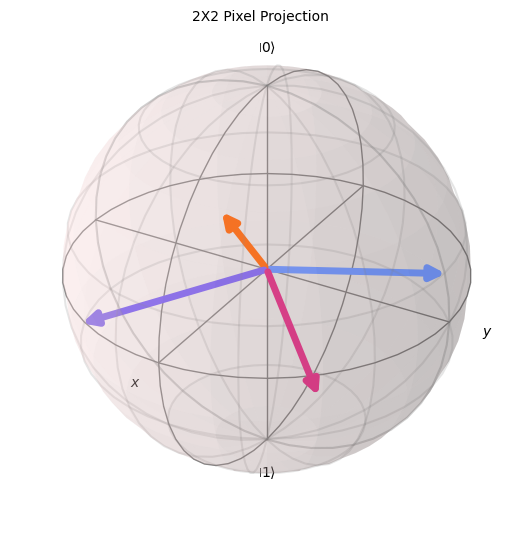

In [7]:
print(point_3d)
plot_bloch_vector(point_3d, title='2X2 Pixel Projection')

# FRQI

## Simulate FRQI in Qiskit

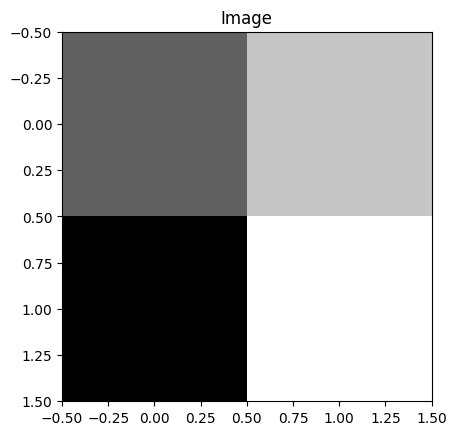

In [36]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [37]:
image

array([[ 78, 136],
       [ 21, 169]])

In [38]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

[77, 136, 19, 171] 
 [ 78 136  21 169]
0.03397 sec


C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3479715401.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)
C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3479715401.py:46: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


In [39]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

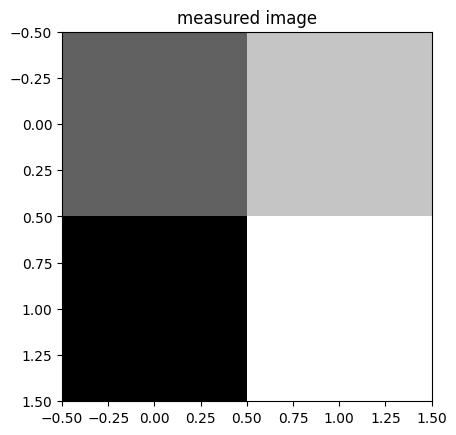

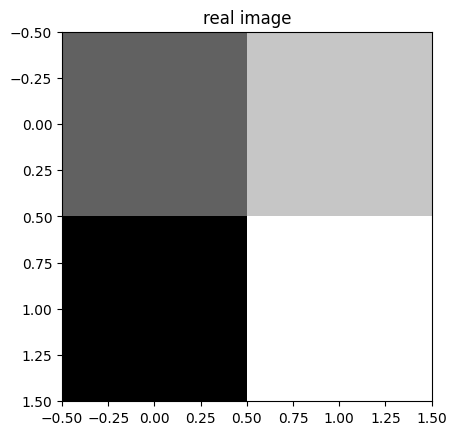

In [40]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

In [41]:
print("Image = ",image, "reconstructed = ",classical_colors)

Image =  [[ 78 136]
 [ 21 169]] reconstructed =  [77, 136, 19, 171]


## Simulate FRQI in IonQ

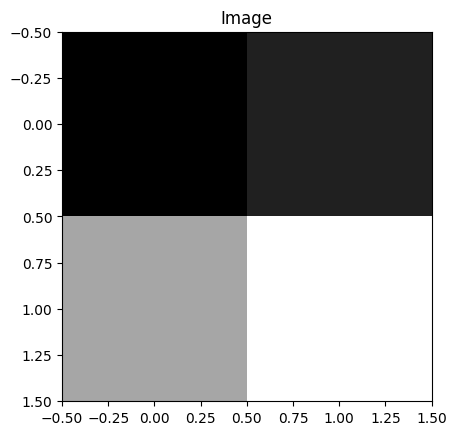

In [23]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [25]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Temp\ipykernel_13920\1658588320.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


[75, 96, 182, 228] 
 [ 81 100 178 230]
8.51246 sec


In [26]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

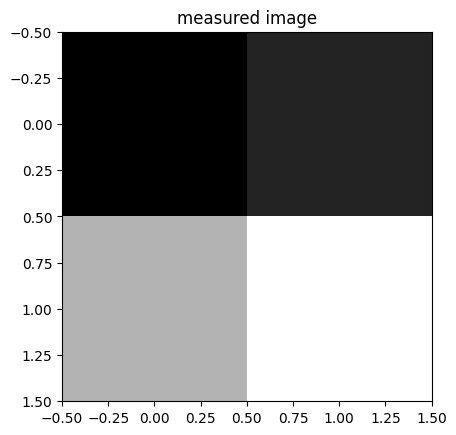

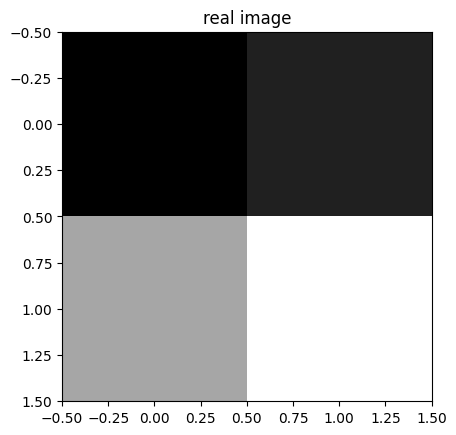

In [27]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

In [28]:
print("Image = ",image, "reconstructed = ",classical_colors)

Image =  [[ 81 100]
 [178 230]] reconstructed =  [75, 96, 182, 228]


# NEQR

## Simulate NEQR in Qiskit

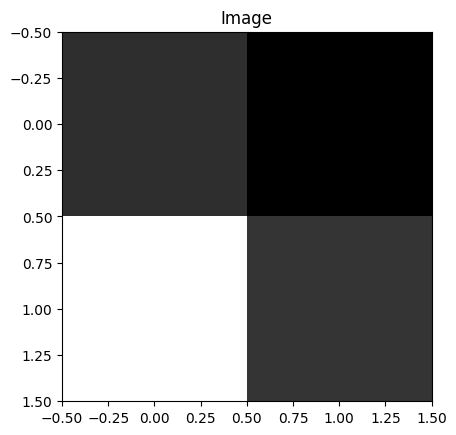

In [42]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3746219321.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)
C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3746219321.py:32: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_neqr = aer_sim.run(qobj)


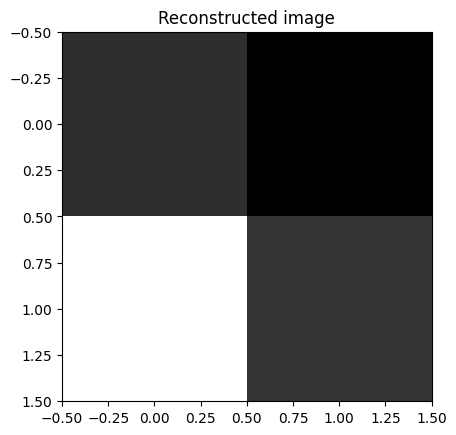

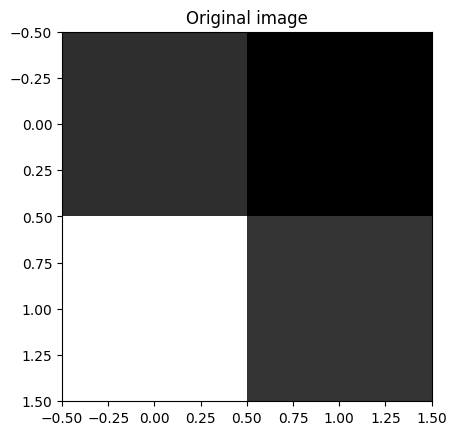

[ 45.   1. 241.  51.] 
 [ 45   1 241  51]
0.06098 sec


In [43]:
start = time.time()

indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))

end = time.time()

plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")

In [44]:
print("Image = ",image, "reconstructed = ",out_image)

Image =  [[ 45   1]
 [241  51]] reconstructed =  [[ 45.   1.]
 [241.  51.]]


## Simulate NEQR in IonQ

In [7]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

In [8]:
simulator_backend = provider.get_backend("ionq_simulator")

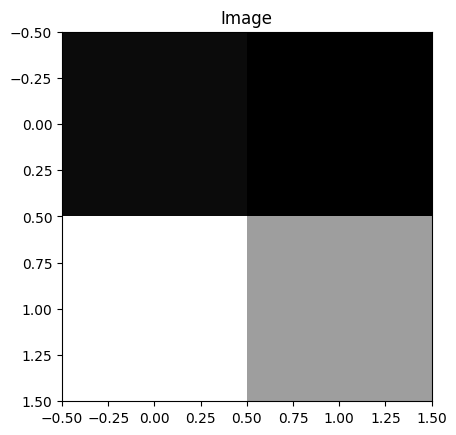

In [29]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3770150665.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)


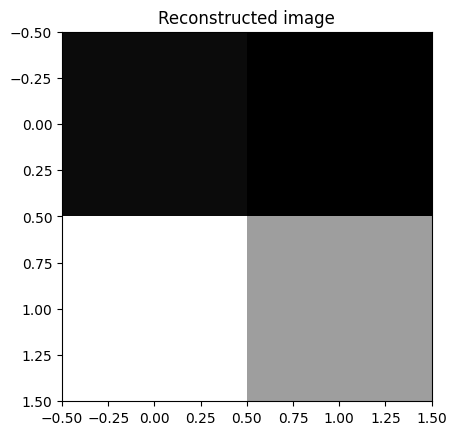

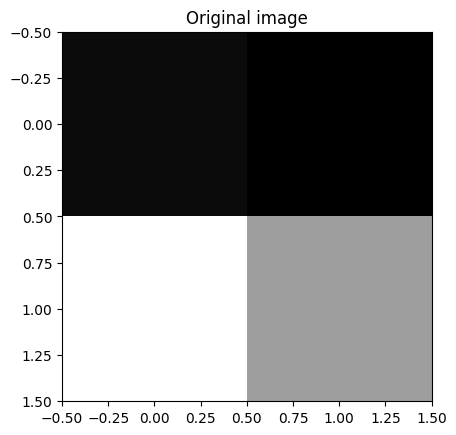

[105.  98. 248. 191.] 
 [105  98 248 191]
8.62745 sec


In [30]:
start = time.time()

indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)

for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))


simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_neqr = simulator_backend.run(t_qc_image)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())
end = time.time()

print(f"{end - start:.5f} sec")

In [31]:
print("Image = ",image, "reconstructed = ",out_image)

Image =  [[105  98]
 [248 191]] reconstructed =  [[105.  98.]
 [248. 191.]]


# OQIM

## Simulate OQIM in Qiskit

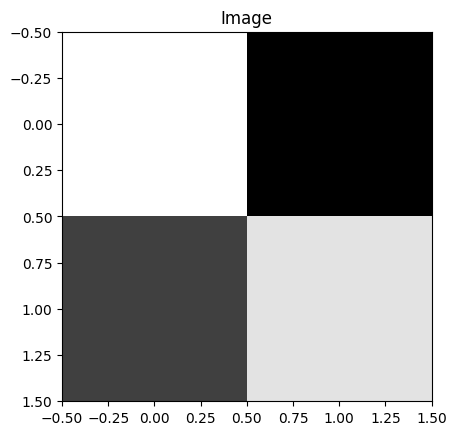

In [9]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_6888\42228475.py:22: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)
C:\Users\HCI\AppData\Local\Temp\ipykernel_6888\42228475.py:67: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


the meauserd colors are 
 [175  77 102 168] 
 the input colors are 
 [179  76 102 168]
the meauserd coordinates are 
 [0 0 2 2]


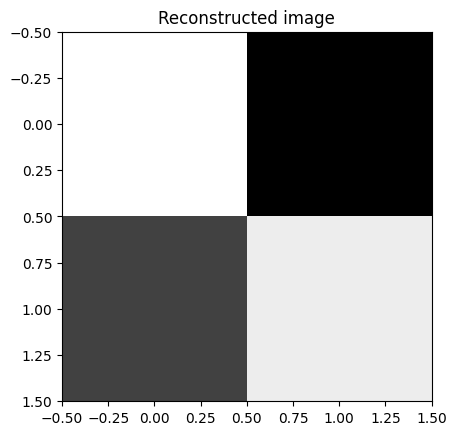

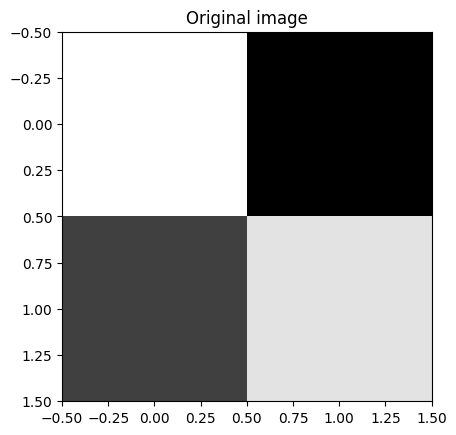

[175  77 102 168] 
 [179  76 102 168]
0.11920 sec


In [10]:
start = time.time()

im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
       
    # qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]):
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

end = time.time()

plt.imshow(output_im, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(output_im.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


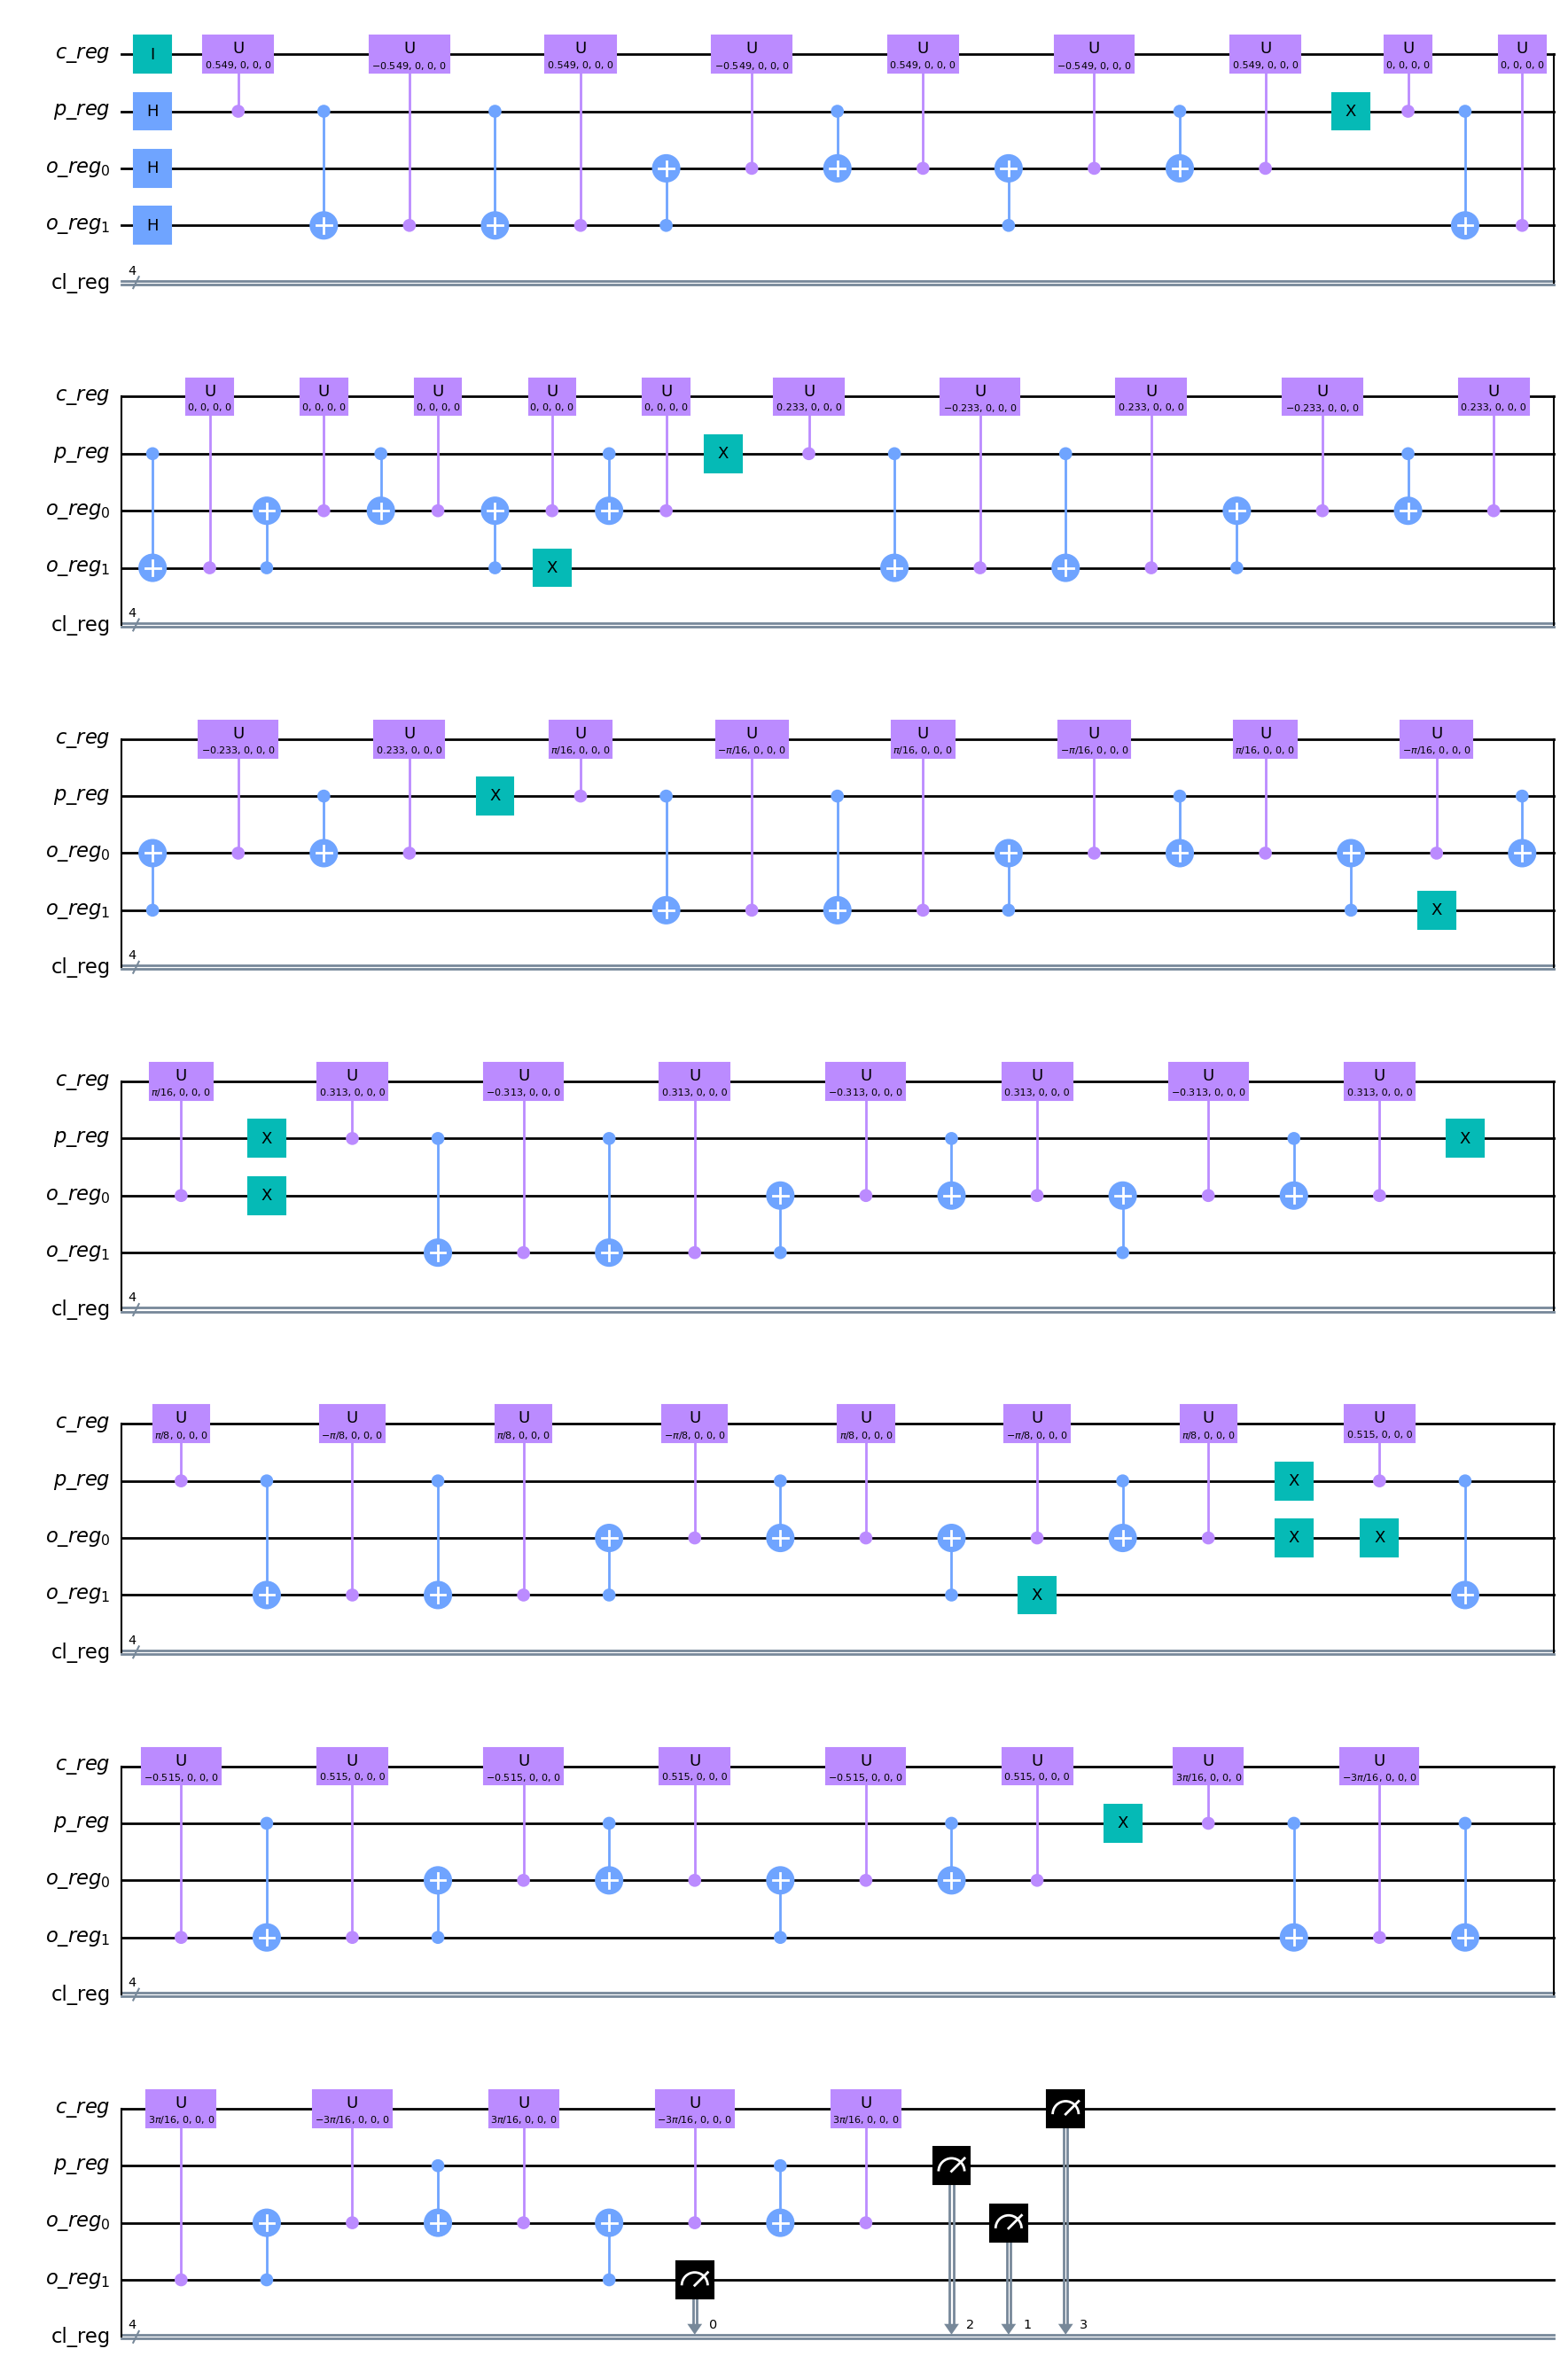

In [11]:
qc_image.draw('mpl')

# Simulate OQIM in IonQ

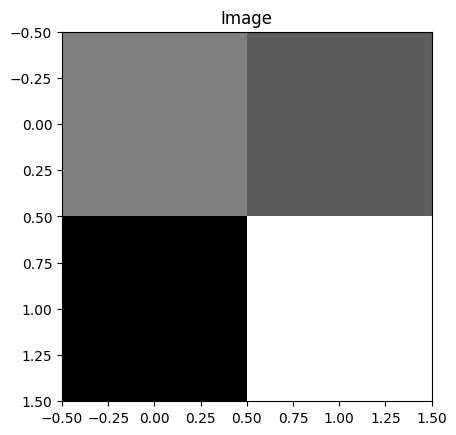

In [53]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\1646045408.py:22: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


the meauserd colors are 
 [132 123  50 223] 
 the input colors are 
 [140 117  55 224]
the meauserd coordinates are 
 [0 1 2 2]


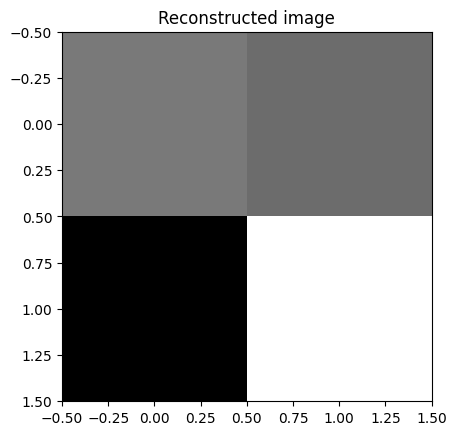

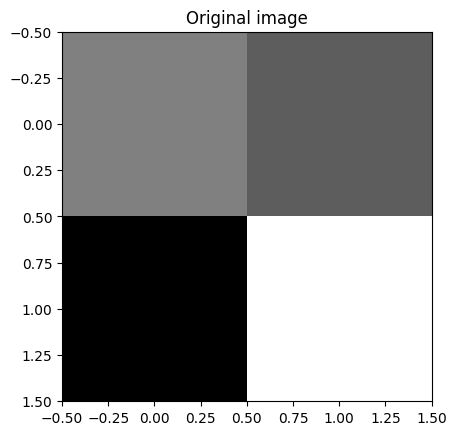

[132 123  50 223] 
 [140 117  55 224]
8.92709 sec


In [54]:
start = time.time()

im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
       
    # qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]):
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

end = time.time()

plt.imshow(output_im, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(output_im.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")

# MCQRI

## Simulate MCQRI in Qiskit

### Step 0 : Dependencies Import

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from qiskit.circuit.library.standard_gates.ry import RYGate

### Step 1 : Image Generating

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


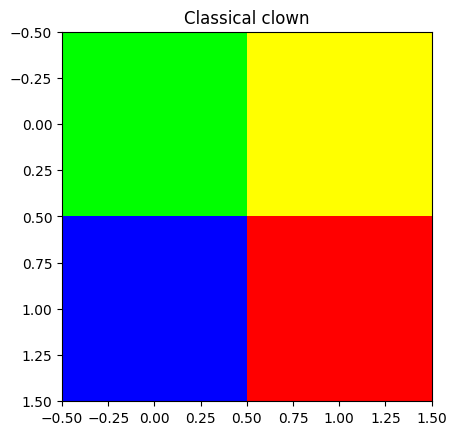

In [2]:
image = np.zeros((2,2,3))

image[:,:,0] = np.array(
           [0, 200, 0, 20]).reshape(2,2)

image[:,:,1] = np.array(
           [150, 150, 0, 0]).reshape(2,2)

image[:,:,2] = np.array(
           [0, 0, 28, 0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical clown')
plt.show()

In [3]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc

### Step 3. Circuit Execution

In [4]:
def run_qc(qc, shots=1000):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    return counts

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


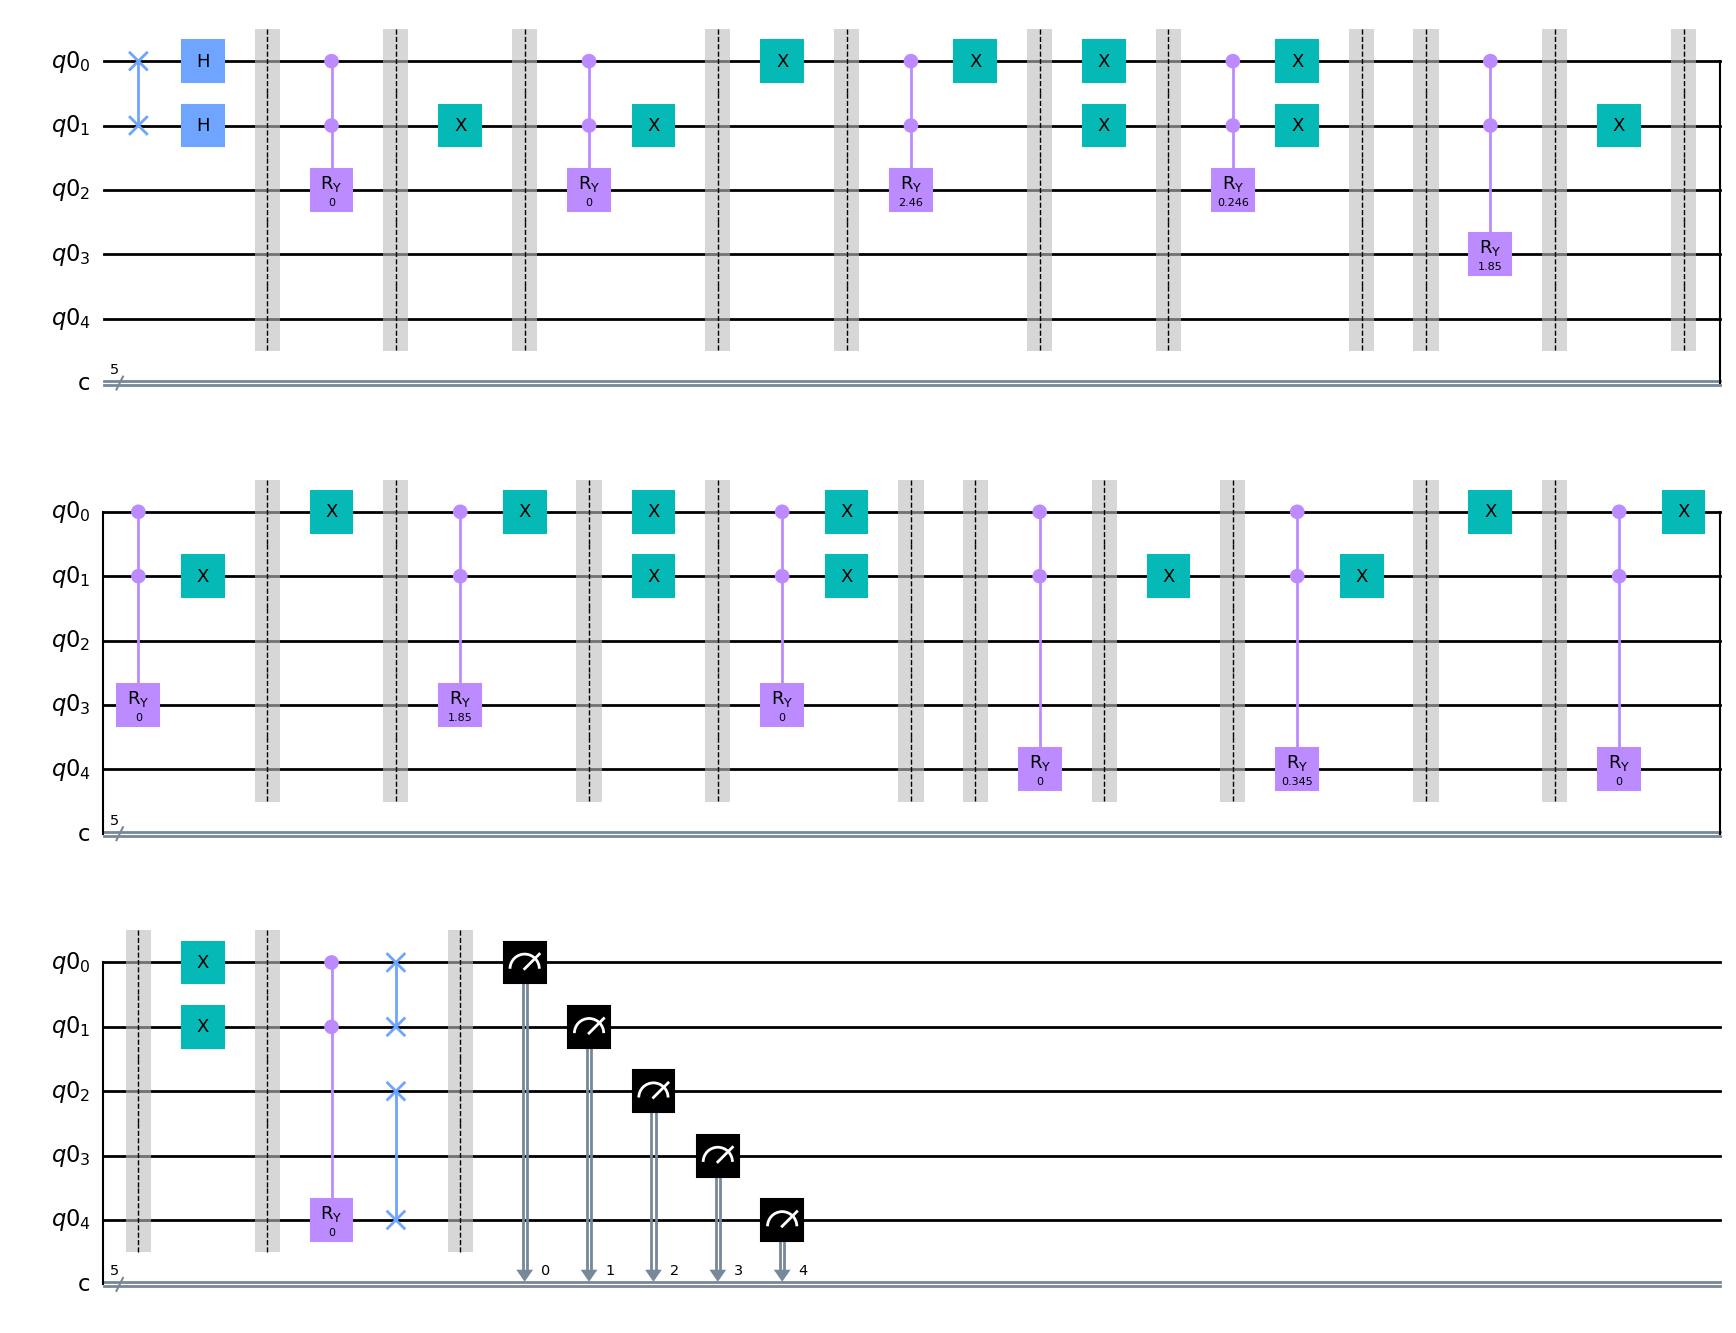

In [8]:
qc.draw('mpl')

### Step 4. Measurements interpretation

In [5]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

In [6]:
start = time.time()

qc = rgb_circ(image)
counts = run_qc(qc)
output_ims = reconstruct_rgb(image, counts, to_print = False)

end = time.time()
print(f"{end - start:.5f} sec")

0.66692 sec


C:\Users\HCI\AppData\Local\Temp\ipykernel_6888\2394357060.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = aer_sim.run(qobj).result()


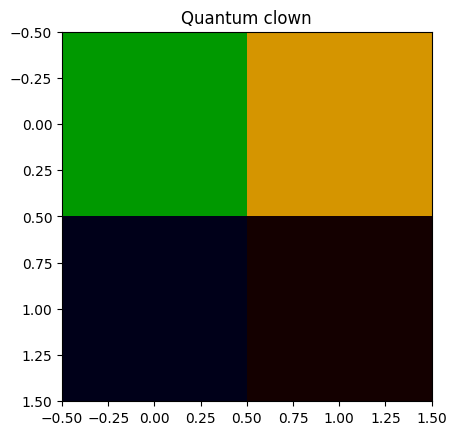

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


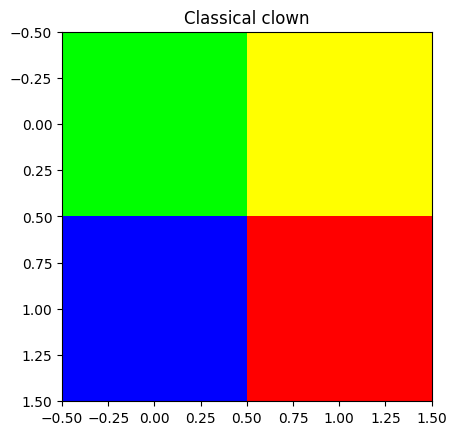

output_ims =  [[[  0 153   0]
  [213 149   0]]

 [[  0   0  25]
  [ 20   0   0]]]  and image =  [[[  0. 150.   0.]
  [200. 150.   0.]]

 [[  0.   0.  28.]
  [ 20.   0.   0.]]]


In [58]:
plt.imshow(output_ims)
plt.title('Quantum clown')
plt.show()

plt.title('Classical clown')
plt.imshow(image)
plt.show()

print("output_ims = ",output_ims, " and","image = ",image)

## Simulate MCQRI in IonQ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


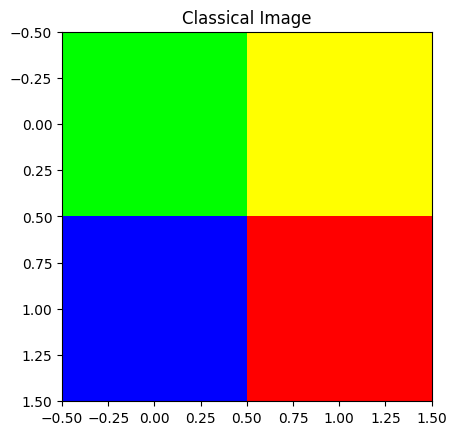

In [59]:
image = np.zeros((2,2,3))

image[:,:,0] = np.array(
           [0, 200, 0, 20]).reshape(2,2)

image[:,:,1] = np.array(
           [150, 150, 0, 0]).reshape(2,2)

image[:,:,2] = np.array(
           [0, 0, 28, 0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical Image')
plt.show()

In [60]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc

In [62]:
def run_qc(qc):
    simulator_backend = provider.get_backend("ionq_simulator")
    t_qc = transpile(qc, simulator_backend)
    job = simulator_backend.run(t_qc)
    result = job.result()
    counts = result.get_counts()
    return counts

In [61]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

In [63]:
start = time.time()

qc = rgb_circ(image)
counts = run_qc(qc)
output_ims = reconstruct_rgb(image, counts, to_print = False)

end = time.time()
print(f"{end - start:.5f} sec")

8.60331 sec


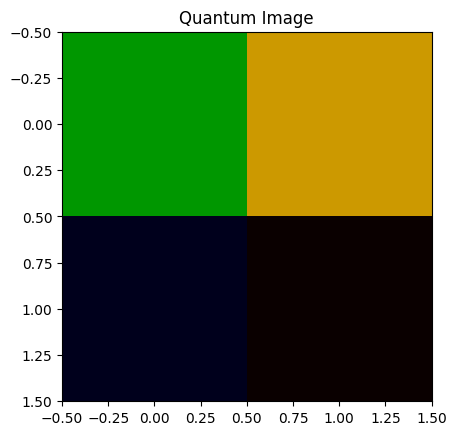

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


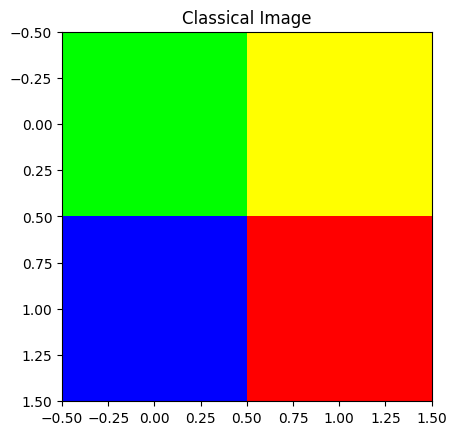

output_ims =  [[[  0 151   0]
  [204 153   0]]

 [[  0   0  28]
  [ 10   0   0]]]  and image =  [[[  0. 150.   0.]
  [200. 150.   0.]]

 [[  0.   0.  28.]
  [ 20.   0.   0.]]]


In [64]:
plt.imshow(output_ims)
plt.title('Quantum Image')
plt.show()

plt.title('Classical Image')
plt.imshow(image)
plt.show()

print("output_ims = ",output_ims, " and","image = ",image)

# Self Study with OQIM